<a href="https://www.kaggle.com/code/aletbm/top4-retail-demand-forecast-mlzc-compet-24?scriptVersionId=222197724" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## MLZoomCamp Competition 2024 from [DataTalks.Club](https://datatalks.club) by [Alexander D. Rios](https://linktr.ee/aletbm)

# 📈 Retail Demand Forecast

<img src="https://i.postimg.cc/4x1GrLrd/glasses-lie-laptop-reflecting-light-from-screen-dark.jpg">

### My leaderboard position

<img src="https://i.postimg.cc/L5yW2gRq/Sin-t-tulo.png">

I'm really thrilled to reach the fourth position. This competition was an interesting challenge where I learned a lot about forecasting with multiple time series.

# Dataset Description
This dataset contains sales information from four stores of one of the retailers over 25 months. Participants are expected to use these files to develop models that can predict customer demand. Additionally, the dataset includes a holdout sample with sales data for a 1-month period for which forecasts should be provided.

`sales.csv`

+ **Purpose**: This file contains aggregated store sales for specific dates.
+ **Columns**:
    + `date`: Sales date
    + `item_id`: A unique identifier for each product
    + `quantity`: Total quantity of product sold per day
    + `price_base`: Average sales price per day
    + `sum_total`: Total daily sales amount
    + `store_id`: Store number

`online.csv`

+ **Purpose**: This file contains aggregated online sales by store for specific dates.
+ **Columns**:
    + `date`: Sales date
    + `item_id`: A unique identifier for each product
    + `quantity`: Total quantity of product sold per day (online)
    + `price_base`: Average sales price per day
    + `sum_total`: Total daily sales amount
    + `store_id`: Store number

`markdowns.csv`

+ **Purpose**: This file provides data on products sold at markdown prices in each store.
+ **Columns**:
    + `date`: Date of markdown
    + `item_id`: A unique identifier for each product
    + `normal_price`: Regular price
    + `price`: Price during markdown
    + `quantity`: Quantity sold at markdown
    + `store_id`: Store number

`price_history.csv`

+ **Purpose**: This file contains price changes data in each store.
+ **Columns**:
    + `date`: Date of price change
    + `item_id`: A unique identifier for each product
    + `price`: Item new price
    + `code`: Price change code
    + `store_id`: Store number

`discounts_history.csv`

+ **Purpose**: Contains historical promo data for each specific store.
+ **Columns**:
    + `date`: Date
    + `item_id`: A unique identifier for each product
    + `sale_price_before_promo`: Price before promo period started
    + `sale_price_time_promo`: Price during the promo period
    + `promo_type_code`: Promo code type
    + `doc_id`: Promo document number
    + `number_disc_day`: Sequential day number of the current promo period
    + `store_id`: Store number
 
`actual_matrix.csv`

+ **Purpose**: Contains the list of products available in stores.
+ **Columns**:
    + `item_id`: A unique identifier for each product
    + `date`: Date of last product appearance in the current matrix
    + `store_id`: Store number

`catalog.csv`

+ **Purpose**: Product catalog with characteristics.
+ **Columns**:
    + `item_id`: A unique identifier for each product
    + `dept_name`: Product department (hierarchy level)
    + `class_name`: Product class (hierarchy level)
    + `subclass_name`: Product subclass (hierarchy level)
    + `item_type`: Product type
    + `weight_volume`: Volumetric weight
    + `weight_netto`: Net weight
    + `fatness`: Fat content

`stores.csv`

+ **Purpose**: Contains stores info data.
+ **Columns**:
    + `store_id`: Store number
    + `division`: Store division
    + `format`: Store format
    + `city`: Location
    + `area`: Store sales area

`test.csv`

+ **Purpose**: Contains the test cases that participants are required to predict.
+ **Columns**:
    + `row_id`: Unique identifier for each record
    + `item_id`: A unique identifier for each product
    + `store_id`: Store number
    + `date`: The date for which the forecast should be made

`sample_submission.csv`

+ **Purpose**: A sample submission file to demonstrate the expected format for the final submission.
+ **Columns**:
    + `row_id`: Unique identifier for each record
    + `quantity`: The predicted amount for the item. Initially set to 0.

# Loading packages

In [1]:
!pip install mplcyberpunk calplot
!pip install scikit-learn --upgrade
!pip install deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8116 sha256=5ef31d1c7fc7e1b30f26b153b29aa179b349d3d3e42e75737db4dcd2fe5d2607
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Import packages

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from calplot import calplot as clp
import mplcyberpunk
plt.style.use("cyberpunk")

from catboost import CatBoostRegressor

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from deep_translator import GoogleTranslator

import gc
import requests
import holidays

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Loading datasets

In [3]:
df_sales = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/sales.csv", index_col=0)
df_online = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/online.csv", index_col=0)
df_markdowns = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/markdowns.csv", index_col=0)
df_price_history = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/price_history.csv", index_col=0)
df_discounts_history = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/discounts_history.csv", index_col=0)
df_actual_matrix = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/actual_matrix.csv", index_col=0)
df_catalog = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv", index_col=0)
df_stores = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/stores.csv", index_col=0)
df_test = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/test.csv", sep=";", index_col="row_id")
df_sample_submission = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/sample_submission.csv", index_col=0)

## Reducing the memory usage

In [4]:
def optimizing_dtypes(df, nameCSV):
    bytesInOneMB = 1048576
    print(f"{nameCSV}: from {round(df.memory_usage().sum()/bytesInOneMB, 2)}MB", end="")
    col_float64 = df.select_dtypes(include=["float64"]).columns.values
    if len(col_float64) > 0:
        df[col_float64] = df.select_dtypes(include=["float64"]).astype("float32", copy=False)
    
    col_int64 = df.select_dtypes(include=["int64"]).columns.values
    if len(col_int64) > 0:
        for col in col_int64:
            if df[col].unique().tolist() == [1, 0] or df[col].unique().tolist() == [0, 1]:
                df[col] = df[col].astype("int8", copy=False)
            else:
                df[col] = df[col].astype("int32", copy=False)
    print(f" reduced to {round(df.memory_usage().sum()/bytesInOneMB,2)}MB")
    return df

dfs = [df_sales, df_online, df_markdowns, df_price_history, df_discounts_history, df_actual_matrix, df_catalog, df_stores, df_test, df_sample_submission]
names = ["sales.csv", "online.csv", "markdowns.csv", "price_history.csv", "discounts_history.csv", "actual_matrix.csv", "catalog.csv", "stores.csv", "test.csv", "sample_submission"]

for df, name in zip(dfs, names):         
    df = optimizing_dtypes(df, nameCSV=name)

sales.csv: from 396.95MB reduced to 283.53MB
online.csv: from 60.0MB reduced to 42.85MB
markdowns.csv: from 0.48MB reduced to 0.34MB
price_history.csv: from 31.98MB reduced to 23.99MB
discounts_history.csv: from 257.27MB reduced to 185.81MB
actual_matrix.csv: from 1.07MB reduced to 0.94MB
catalog.csv: from 15.09MB reduced to 12.58MB
stores.csv: from 0.0MB reduced to 0.0MB
test.csv: from 26.97MB reduced to 23.6MB
sample_submission: from 13.48MB reduced to 10.11MB


# Exploratory Data Analysis
## Joining the datasets about sales 

## Sales

`sales.csv`
+ **Purpose**: This file contains aggregated store sales for specific dates.
+ **Columns**:
    + `date`: Sales date
    + `item_id`: A unique identifier for each product
    + `quantity`: Total quantity of product sold per day
    + `price_base`: Average sales price per day
    + `sum_total`: Total daily sales amount
    + `store_id`: Store number

where:

$ price_{base} = \frac{sum_{total}}{quantity} $

### Let's take a look at the sales dataset

In [5]:
df_sales.date = pd.to_datetime(df_sales.date)
df_sales.price_base = df_sales.sum_total/df_sales.quantity
df_sales = df_sales.sort_values(["date", "item_id", "store_id"])

df_sales.head()

,date,item_id,quantity,price_base,sum_total,store_id
11783134,2022-08-28,001829cb707d,7.0000,134.7600,943.3200,1
15978661,2022-08-28,001829cb707d,1.0000,148.0000,148.0000,2
11785258,2022-08-28,0022b986c8f0,2.0000,59.9000,119.8000,1
15978392,2022-08-28,00274a69c705,1.0000,35.9000,35.9000,2
19739464,2022-08-28,00274a69c705,5.0000,35.9000,179.5000,3


### Statistical description 

In [6]:
df_sales.describe(include="all")

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,date,item_id,quantity,price_base,sum_total,store_id
count,7432685,7432685,7432685.0000,7431652.0000,7432685.0000,7432685.0000
unique,NaN,28182,NaN,NaN,NaN,NaN
top,NaN,e5b2b6f57ea7,NaN,NaN,NaN,NaN
freq,NaN,2571,NaN,NaN,NaN,NaN
mean,2023-11-07 01:34:58.084931584,NaN,5.6424,NaN,761.2797,2.0414
min,2022-08-28 00:00:00,NaN,-500.0000,-inf,-20410.8008,1.0000
25%,2023-05-04 00:00:00,NaN,1.0000,60.0000,127.9000,1.0000
50%,2023-12-25 00:00:00,NaN,2.0000,109.9000,259.6000,2.0000
75%,2024-05-13 00:00:00,NaN,4.6720,199.9000,599.0000,3.0000
max,2024-09-26 00:00:00,NaN,4952.0000,inf,686524.1875,4.0000


Some important aspects:

+ The records for the year 2022 start in the eighth month, while the records for the year 2024 end in the ninth month.
+ The dataset contains 28182 different items.
+ The `quantity` feature contains negative values. Is this possible? Furthermore, the median value is too small compared to the maximum value; therefore, this feature is biased.
+ The `price_base` feature has a maximum/minimum value of infinity. This is an error!
+ The minimum value of the `sum_total` feature is negative. Do the negative values have an important meaning?

### Let's take a look at the atypical values

In [7]:
mask = (df_sales.quantity <= 0) | (df_sales.price_base <= 0) | (df_sales.sum_total <= 0)
df_sales[mask]

,date,item_id,quantity,price_base,sum_total,store_id
15978668,2022-08-28,02449bc5f33c,0.0000,NaN,0.0000,2
11784222,2022-08-28,57fd9954a3d7,0.0000,inf,0.9000,1
11781815,2022-08-28,947dc1d486a8,-1.0000,410.0800,-410.0800,1
11782086,2022-08-28,986dbd10687c,1.0000,0.0000,0.0000,1
15978450,2022-08-28,99d388c37359,3.0000,0.0000,0.0000,2
...,...,...,...,...,...,...
2044919,2024-09-26,6cf7fb7b929b,0.0000,inf,0.9000,1
2045107,2024-09-26,7e86f0063b6c,0.0000,inf,0.9000,1
21736169,2024-09-26,8db850cb9f41,-1.0000,229.9000,-229.9000,4
21734915,2024-09-26,a1df7666038c,0.0000,-inf,-8.9000,4


All these records present strange values. A record with zero or negative quantity is impossible. A product with a negative price base does not exist. These records must be corrected or removed.

In [8]:
df_sales.drop(df_sales[mask].index, axis=0, inplace=True)

### Let's check missing values

In [9]:
df_sales.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

## Testing set

`test.csv`

+ **Purpose**: Contains the test cases that participants are required to predict.
+ **Columns**:
    + `row_id`: Unique identifier for each record
    + `item_id`: A unique identifier for each product
    + `store_id`: Store number
    + `date`: The date for which the forecast should be made

### Let's take a look at the test dataset

In [10]:
df_test.date = pd.to_datetime(df_test.date)
df_test.head()

<ipython-input-10-f5f9da13423a>:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_test.date = pd.to_datetime(df_test.date)


,item_id,store_id,date
row_id,,,
0,c578da8e8841,1,2024-09-27
1,c578da8e8841,1,2024-09-28
2,c578da8e8841,1,2024-09-29
3,c578da8e8841,1,2024-09-30
4,c578da8e8841,1,2024-10-01


### Statistical description

In [11]:
df_test.describe(include="all")

,item_id,store_id,date
count,883680,883680.0000,883680
unique,13636,NaN,NaN
top,c578da8e8841,NaN,NaN
freq,120,NaN,NaN
mean,NaN,2.4788,2024-10-11 11:59:59.999999744
min,NaN,1.0000,2024-09-27 00:00:00
25%,NaN,1.0000,2024-10-04 00:00:00
50%,NaN,2.0000,2024-10-11 12:00:00
75%,NaN,4.0000,2024-10-19 00:00:00
max,NaN,4.0000,2024-10-26 00:00:00


+ The records for the year 2024 start in the ninth month and end in the tenth month.
+ The dataset contains 13636 different items.

## Online Sales

`online.csv`

+ **Purpose**: This file contains aggregated online sales by store for specific dates.
+ **Columns**:
    + `date`: Sales date
    + `item_id`: A unique identifier for each product
    + `quantity`: Total quantity of product sold per day (online)
    + `price_base`: Average sales price per day
    + `sum_total`: Total daily sales amount
    + `store_id`: Store number

where:

$ price_{base} = \frac{sum_{total}}{quantity} $

### Let's take a look at the online sales dataset

In [12]:
df_online.date = pd.to_datetime(df_online.date)
df_online.price_base = df_online.sum_total/df_online.quantity
df_online = df_online.sort_values(["date", "item_id", "store_id"])

df_online.head()

,date,item_id,quantity,price_base,sum_total,store_id
1680273,2022-08-28,0082d7c4d384,0.8000,237.5000,190.0000,1
1679882,2022-08-28,00aa37841bff,1.0000,58.5500,58.5500,1
1679638,2022-08-28,01b6310ee3bf,2.0000,26.0800,52.1600,1
1679608,2022-08-28,021e0d49cd97,1.0000,168.7400,168.7400,1
1679880,2022-08-28,023861d4f02f,1.0000,34.7800,34.7800,1


### Statistical description 

In [13]:
df_online.describe(include="all")

,date,item_id,quantity,price_base,sum_total,store_id
count,1123412,1123412,1123412.0000,1123412.0000,1123412.0000,1123412.0000
unique,NaN,18405,NaN,NaN,NaN,NaN
top,NaN,a162df3be29c,NaN,NaN,NaN,NaN
freq,NaN,1047,NaN,NaN,NaN,NaN
mean,2023-10-25 13:29:06.836957440,NaN,2.1948,149.7955,225.9123,1.6594
min,2022-08-28 00:00:00,NaN,0.0020,-8458.3330,-341.8800,1.0000
25%,2023-03-25 00:00:00,NaN,1.0000,43.3400,61.4800,1.0000
50%,2023-12-19 00:00:00,NaN,1.0000,78.6945,110.9600,1.0000
75%,2024-05-09 00:00:00,NaN,2.0000,169.2617,222.9000,1.0000
max,2024-09-26 00:00:00,NaN,999.0000,12171.6201,43556.4414,4.0000


Some important aspects:

+ The records for the year 2022 start in the eighth month, while the records for the year 2024 end in the ninth month.
+ The dataset contains 28182 different items.
+ The `quantity` feature contains negative values. Is this possible? Furthermore, the median value is too small compared to the maximum value; therefore, this feature is biased.
+ The `price_base` feature has a minimum value of negative. Furthermore, the median value is too small compared to the maximum value; therefore, this feature is biased.
+ The minimum value of the `sum_total` feature is negative. Do the negative values have an important meaning?

### Let's take a look at the atypical values

In [14]:
mask = (df_online.quantity <= 0) | (df_online.price_base <= 0) | (df_online.sum_total <= 0)
df_online[mask]

,date,item_id,quantity,price_base,sum_total,store_id
1698296,2022-09-12,44c942fe217c,3.0000,-113.9600,-341.8800,1
1789380,2022-11-23,0f6c32f3819f,0.1400,-12.6429,-1.7700,1
1910730,2023-02-19,e6a089921dee,0.0060,-8458.3330,-50.7500,1
48088,2023-09-30,f97e09465bd9,0.0040,-110.0000,-0.4400,1
80034,2023-10-30,95f7fc6882d6,0.0400,-54.5000,-2.1800,1
444802,2024-09-19,b178700122d3,0.0530,-452.2641,-23.9700,1


All these records present strange values. A record with zero or negative quantity is impossible. A product with a negative price base does not exist. These records must be corrected or removed.

In [15]:
df_online.drop(df_online[mask].index, axis=0, inplace=True)

### Let's check missing values in the online sales dataset

In [16]:
df_online.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

### Joining the online sales and the normal sales datasets

In [17]:
df_online = df_online.rename(columns={"price_base":"price_base_online", "sum_total":"sum_total_online"})
df_online["online"] = True

df = pd.merge(df_sales, df_online, on=['date', 'item_id', "store_id"], how='outer', suffixes=('_x', '_y'))
df["quantity"] = df[['quantity_x', 'quantity_y']].sum(axis=1)

df = df[df_sales.columns.to_list() #+ ["online", "price_base_online", "sum_total_online"]
        ]
#df["online"] = df["online"].fillna(False)
#df.online = df.online.astype(bool)
df = df.fillna(0)

df.head()

,date,item_id,quantity,price_base,sum_total,store_id
0,2022-08-28,001829cb707d,7.0000,134.7600,943.3200,1
1,2022-08-28,001829cb707d,1.0000,148.0000,148.0000,2
2,2022-08-28,0022b986c8f0,2.0000,59.9000,119.8000,1
3,2022-08-28,00274a69c705,1.0000,35.9000,35.9000,2
4,2022-08-28,00274a69c705,5.0000,35.9000,179.5000,3


### Let's check missing values in the complete dataset

In [18]:
df.isna().sum()

date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

## Markdowns

`markdowns.csv`

+ **Purpose**: This file provides data on products sold at markdown prices in each store.
+ **Columns**:
    + `date`: Date of markdown
    + `item_id`: A unique identifier for each product
    + `normal_price`: Regular price
    + `price`: Price during markdown
    + `quantity`: Quantity sold at markdown
    + `store_id`: Store number

### Let's take a look at the markdowns dataset

In [19]:
df_markdowns.date = pd.to_datetime(df_markdowns.date)
df_markdowns.head()

,date,item_id,normal_price,price,quantity,store_id
0,2023-08-01,bc2f82a22e11,189.0000,100.0000,8.0000,1
1,2023-08-01,389412076801,179.0000,100.0000,5.0000,1
2,2023-08-01,0e39cf5d57c1,149.0000,100.0000,5.0000,1
3,2023-08-01,dd94e2bc5601,149.0000,100.0000,1.0000,1
4,2023-08-01,e60d890f2812,369.0000,270.0000,1.0000,1


### Statistical description 

In [20]:
df_markdowns.describe(include="all")

,date,item_id,normal_price,price,quantity,store_id
count,8979,8979,8979.0000,8979.0000,8979.0000,8979.0000
unique,NaN,313,NaN,NaN,NaN,NaN
top,NaN,e7ff6ea67040,NaN,NaN,NaN,NaN
freq,NaN,491,NaN,NaN,NaN,NaN
mean,2023-09-27 17:07:11.807551232,NaN,358.3528,213.2966,3.0705,1.9128
min,2022-08-28 00:00:00,NaN,0.0000,12.5000,0.1150,1.0000
25%,2023-03-16 00:00:00,NaN,189.0000,100.0000,1.0000,1.0000
50%,2023-10-18 00:00:00,NaN,239.0000,150.0000,2.0000,2.0000
75%,2024-04-14 00:00:00,NaN,549.0000,330.0000,4.0000,2.0000
max,2024-09-26 00:00:00,NaN,2790.0000,1380.5000,120.0000,4.0000


+ The `normal_price`, `price`, and `quantity` features have a biased distribution.
+ Meanwhile, the `normal_price` feature contains zero values. Is this possible?

### Let's take a look at the atypical values

In [21]:
mask = df_markdowns.normal_price <= 0
df_markdowns[mask]

,date,item_id,normal_price,price,quantity,store_id
17897,2024-05-20,8b7268eb2b33,0.0000,299.1000,2.0000,2
34321,2024-05-20,8b7268eb2b33,0.0000,349.0000,1.0000,4


If `normal_price` reflects the price before the markdown, then the `price` feature shouldn't be less than `normal_price`.

In [22]:
df_markdowns.drop(df_markdowns[mask].index, axis=0, inplace=True)

### Let's check missing values

In [23]:
df_markdowns.isna().sum()

date            0
item_id         0
normal_price    0
price           0
quantity        0
store_id        0
dtype: int64

### Joining the sales and markdowns

Markdowns can be considered atypical values since they generally occur only occasionally. For this reason, I excluded them from the complete dataset.
```
df_markdowns = df_markdowns.rename(columns={"price":"price_markdown", "normal_price":"regular_price_markdown"})
df_markdowns["markdown"] = True
df_markdowns["sum_total_markdown"] = df_markdowns["price_markdown"] * df_markdowns["quantity"]

columns = df.columns.to_list()
df = pd.merge(df, df_markdowns, on=['date', 'item_id', "store_id"], how='outer', suffixes=('_x', '_y'))
df["quantity"] = df[['quantity_x', 'quantity_y']].sum(axis=1)

df = df[columns #+ ["markdown", 
                   #"price_markdown", 
                   #"regular_price_markdown", 
                   #"sum_total_markdown"
                  #]
        ]
#df["markdown"] = df["markdown"].fillna(False)
df = df.fillna(0)

df.head()
```

## History discounts

`discounts_history.csv`

+ **Purpose**: Contains historical promo data for each specific store.
+ **Columns**:
    + `date`: Date
    + `item_id`: A unique identifier for each product
    + `sale_price_before_promo`: Price before promo period started
    + `sale_price_time_promo`: Price during the promo period
    + `promo_type_code`: Promo code type
    + `doc_id`: Promo document number
    + `number_disc_day`: Sequential day number of the current promo period
    + `store_id`: Store number

### Let's take a look at the discounts history dataset

In [24]:
df_discounts_history.date = pd.to_datetime(df_discounts_history.date)
df_discounts_history.head()

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
3648316,2022-08-28,cde97a9ec3ef,729.9000,669.9000,6.0000,89ea9f0c-1c08-11ed-ad4d-005056861040,13.0000,1
3648317,2022-08-28,2906fbc9e11c,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1
3648318,2022-08-28,c48c3a3d8c01,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1
3648319,2022-08-28,f85243ca61e6,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1
3648320,2022-08-28,27ce75534065,129.9000,99.9000,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0000,1


### Statistical description 

In [25]:
df_discounts_history.describe(include="all")

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
count,3746744,3746744,3746744.0000,3746744.0000,3428898.0000,3746744,3746744.0000,3746744.0000
unique,NaN,16081,NaN,NaN,NaN,13763,NaN,NaN
top,NaN,8250099a8aff,NaN,NaN,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,NaN,NaN
freq,NaN,34108,NaN,NaN,NaN,196121,NaN,NaN
mean,2024-06-17 11:33:20.464616960,NaN,425.3020,334.0184,5.6623,NaN,286.3346,2.0350
min,2022-08-28 00:00:00,NaN,0.0000,0.0000,1.0000,NaN,1.0000,1.0000
25%,2023-05-01 00:00:00,NaN,84.9000,69.9000,5.0000,NaN,4.0000,1.0000
50%,2024-01-13 00:00:00,NaN,179.9000,149.9000,5.0000,NaN,8.0000,2.0000
75%,2024-06-18 00:00:00,NaN,499.9000,389.9000,6.0000,NaN,13.0000,3.0000
max,2045-12-31 00:00:00,NaN,16999.9004,15999.9004,44.0000,NaN,8766.0000,4.0000


Some important aspects:
+ The date feature presents an atypical value; the maximum date is in the year 2045. Our test dataset has a maximum date of 2024-10-26. Therefore, the dates in the discount history dataset must be less than or equal to this date.
+ Can `sales_before_promo` be equal to zero? If this is the value before the promo, then what is the price at the time of the promo? Clearly, this is an error.
+ If the sale_price_time_promo is equal to zero, it means the product was free. I believe that this value is an error.

### Let's take a look at the atypical values

In [26]:
mask = (df_discounts_history.sale_price_before_promo <= 0) | (df_discounts_history.sale_price_time_promo <= 0) | (df_discounts_history.date > df_test.date.max())
df_discounts_history[mask]

,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
4607127,2023-10-10,8c700aaab569,0.0000,99.9000,5.0000,67622ca8-66b5-11ee-bb94-005056afbcf1,1.0000,1
4607139,2023-10-10,895f92853c33,0.0000,99.9000,5.0000,67622ca8-66b5-11ee-bb94-005056afbcf1,1.0000,1
4607962,2023-10-10,f21d7bc1cb2a,0.0000,699.9000,5.0000,67622ca8-66b5-11ee-bb94-005056afbcf1,1.0000,1
4608273,2023-10-10,f1d2c45681c0,0.0000,599.9000,5.0000,67622ca8-66b5-11ee-bb94-005056afbcf1,1.0000,1
4608431,2023-10-10,2a04a8340a60,0.0000,79.9000,5.0000,67622ca8-66b5-11ee-bb94-005056afbcf1,1.0000,1
...,...,...,...,...,...,...,...,...
11420928,2045-12-31,23b18d1f7da9,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420929,2045-12-31,e5b2b6f57ea7,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420930,2045-12-31,2c007023f650,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4
11420931,2045-12-31,9f716dce9a57,59.9000,59.9000,NaN,baa3d490-5529-11ed-bb91-005056afbcf1,8766.0000,4


These records are outliers, so we can remove them.

In [27]:
df_discounts_history.drop(df_discounts_history[mask].index, axis=0, inplace=True)

### Let's check missing values

In [28]:
df_discounts_history.isna().sum()

date                           0
item_id                        0
sale_price_before_promo        0
sale_price_time_promo          0
promo_type_code            81436
doc_id                         0
number_disc_day                0
store_id                       0
dtype: int64

### Joining the sales and the history discounts datasets

The same reason that we aren't join markdowns at the complete dataset, discount generally occur only occasionally. For this reason, I excluded them.
```
df_discounts_history["promo_day"] = True

columns = df.columns.to_list()
df = pd.merge(df, df_discounts_history, how='left', left_on=['date', 'item_id', "store_id"], right_on=['date', 'item_id', "store_id"], suffixes=('_x', '_y'))
df = df[columns + ["promo_day", "sale_price_before_promo", "sale_price_time_promo", "promo_type_code", "doc_id", "number_disc_day"]]

df["promo_discount"] = df['sale_price_before_promo'] - df['sale_price_time_promo']
df["promo_day"] = df["promo_day"].fillna(False)
df[["sale_price_before_promo", "sale_price_time_promo", "promo_discount", "number_disc_day"]] = df[["sale_price_before_promo", "sale_price_time_promo", "promo_discount", "number_disc_day"]].fillna(0)
df.head()
```
```
for col in ["promo_type_code", "doc_id"]:
    perc = df[col].isna().sum() * 100 / len(df)
    print(f"The missing values in the {col} feature account for {round(perc, 2)}% (>40%) of the total records.")
```
```
df.drop(["promo_type_code", "doc_id"], axis=1, inplace=True)
```

## Stores

`stores.csv`

+ **Purpose**: Contains stores info data.
+ **Columns**:
    + `store_id`: Store number
    + `division`: Store division
    + `format`: Store format
    + `city`: Location
    + `area`: Store sales area

### Let's take a look at the stores dataset

In [29]:
df_stores.head()

,store_id,division,format,city,area
0,4,Div1,MaxiEuro,City3,1887
1,3,Div2,Format-7 express,City2,109
2,2,Div2,Format-6,City1,210
3,1,Div1,Format-1,City1,1500


### Joining the sales and the stores datasets

In [30]:
df = df.merge(df_stores, how='left', left_on=["store_id"], right_on=["store_id"])
df.head()

,date,item_id,quantity,price_base,sum_total,store_id,division,format,city,area
0,2022-08-28,001829cb707d,7.0000,134.7600,943.3200,1,Div1,Format-1,City1,1500
1,2022-08-28,001829cb707d,1.0000,148.0000,148.0000,2,Div2,Format-6,City1,210
2,2022-08-28,0022b986c8f0,2.0000,59.9000,119.8000,1,Div1,Format-1,City1,1500
3,2022-08-28,00274a69c705,1.0000,35.9000,35.9000,2,Div2,Format-6,City1,210
4,2022-08-28,00274a69c705,5.0000,35.9000,179.5000,3,Div2,Format-7 express,City2,109


### Joining the test and the stores datasets

In [31]:
df_test = df_test.merge(df_stores, how='left', left_on=["store_id"], right_on=["store_id"])
df_test.head()

,item_id,store_id,date,division,format,city,area
0,c578da8e8841,1,2024-09-27,Div1,Format-1,City1,1500
1,c578da8e8841,1,2024-09-28,Div1,Format-1,City1,1500
2,c578da8e8841,1,2024-09-29,Div1,Format-1,City1,1500
3,c578da8e8841,1,2024-09-30,Div1,Format-1,City1,1500
4,c578da8e8841,1,2024-10-01,Div1,Format-1,City1,1500


## Catalog

`catalog.csv`

+ **Purpose**: Product catalog with characteristics.
+ **Columns**:
    + `item_id`: A unique identifier for each product
    + `dept_name`: Product department (hierarchy level)
    + `class_name`: Product class (hierarchy level)
    + `subclass_name`: Product subclass (hierarchy level)
    + `item_type`: Product type
    + `weight_volume`: Volumetric weight
    + `weight_netto`: Net weight
    + `fatness`: Fat content

### Translating the catalog.csv

This dataset contains information in Russian. I created the following code to translate it into English using Google Translator through the `deep-translator` package:

In [32]:
df_catalog = pd.read_csv("/kaggle/input/ml-zoomcamp-2024-competition/catalog.csv", index_col=0)

dept_name = df_catalog.dept_name.unique()
for name in dept_name:
    df_catalog.loc[df_catalog['dept_name'] == name, 'dept_name'] = GoogleTranslator(source='ru', target='en').translate(name).lower().replace(' ', '_')

class_name = df_catalog.class_name.unique()
for name in class_name:
    df_catalog.loc[df_catalog['class_name'] == name, 'class_name'] = GoogleTranslator(source='ru', target='en').translate(name).lower().replace(' ', '_')

subclass_name = df_catalog.subclass_name.unique()
for name in subclass_name:
    df_catalog.loc[df_catalog['subclass_name'] == name, 'subclass_name'] = GoogleTranslator(source='ru', target='en').translate(name).lower().replace(' ', '_')

df_catalog.item_type = df_catalog.item_type.fillna("other")

item_type = df_catalog.item_type.unique()
for name in item_type:
    df_catalog.loc[df_catalog['item_type'] == name, 'item_type'] = GoogleTranslator(source='ru', target='en').translate(name).lower().replace(' ', '_')

df_catalog.to_csv("/kaggle/working/translated_catalog.csv", index=True)

### Let's take a look at the catalog dataset

In [33]:
df_catalog.head()

,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,da17e2d5feda,paper_and_wool_products,paper_products,wet_wipes,other,150.0000,NaN,NaN
1,614de2b96018,paper_and_wool_products,wool_products,cotton_pads,other,30.0000,NaN,NaN
2,0c1f1f3e3e11,paper_and_wool_products,wool_products,cotton_pads,other,NaN,NaN,NaN
3,71a7fa99f005,home_goods,dishes,cookware,other,NaN,NaN,NaN
4,ec1bd4d59fe9,paper_and_wool_products,wool_products,cotton_pads,other,30.0000,NaN,NaN


### Joining the sales and the catalog datasets

In [34]:
df = df.merge(df_catalog, how='left', left_on=["item_id"], right_on=["item_id"])
df.head()

,date,item_id,quantity,price_base,sum_total,store_id,division,format,city,area,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,2022-08-28,001829cb707d,7.0000,134.7600,943.3200,1,Div1,Format-1,City1,1500,cream,cream,drinking_cream,drinking,0.5000,0.5000,10.0000
1,2022-08-28,001829cb707d,1.0000,148.0000,148.0000,2,Div2,Format-6,City1,210,cream,cream,drinking_cream,drinking,0.5000,0.5000,10.0000
2,2022-08-28,0022b986c8f0,2.0000,59.9000,119.8000,1,Div1,Format-1,City1,1500,"spices,_seasonings",monospices,monospices,"spices,_seasoning",0.0200,0.0200,NaN
3,2022-08-28,00274a69c705,1.0000,35.9000,35.9000,2,Div2,Format-6,City1,210,sweet_flour_products,cookie,packaged_cookies,cookie,0.1300,0.1300,NaN
4,2022-08-28,00274a69c705,5.0000,35.9000,179.5000,3,Div2,Format-7 express,City2,109,sweet_flour_products,cookie,packaged_cookies,cookie,0.1300,0.1300,NaN


### Joining the test and the catalog datasets

In [35]:
df_test = df_test.merge(df_catalog, how='left', left_on=["item_id"], right_on=["item_id"])
df_test.head()

,item_id,store_id,date,division,format,city,area,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,c578da8e8841,1,2024-09-27,Div1,Format-1,City1,1500,tobacco_products,cigarettes,cigarettes,other,NaN,NaN,NaN
1,c578da8e8841,1,2024-09-28,Div1,Format-1,City1,1500,tobacco_products,cigarettes,cigarettes,other,NaN,NaN,NaN
2,c578da8e8841,1,2024-09-29,Div1,Format-1,City1,1500,tobacco_products,cigarettes,cigarettes,other,NaN,NaN,NaN
3,c578da8e8841,1,2024-09-30,Div1,Format-1,City1,1500,tobacco_products,cigarettes,cigarettes,other,NaN,NaN,NaN
4,c578da8e8841,1,2024-10-01,Div1,Format-1,City1,1500,tobacco_products,cigarettes,cigarettes,other,NaN,NaN,NaN


### Looking for missing values in the sales and the test dataset

In [36]:
def get_colums_with_nan(df):
    return df.columns[df.isna().sum() > 0]
    
cols = get_colums_with_nan(df)

df[cols].isna().sum()*100/len(df)

dept_name        0.4891
class_name       0.4891
subclass_name    0.4891
item_type        0.4891
weight_volume   19.4032
weight_netto    15.1122
fatness         91.2581
dtype: float64

In [37]:
df_test[cols].isna().sum()*100/len(df_test)

dept_name        6.3485
class_name       6.3485
subclass_name    6.3485
item_type        6.3485
weight_volume   21.9514
weight_netto    16.2446
fatness         94.7787
dtype: float64

We'll delete the features which have more than 40% of missing values.

#### Dropping missing values

In [38]:
df = df.drop(["fatness"], axis=1)
df_test = df_test.drop(["fatness"], axis=1)

#### Filling in missing values
These items with missing `dept_name`, `class_name`, `subclass_name`, and `item_type` are items that are either not in the catalog or have not been classified. For these reasons, I classified them under the `other` category.

In [39]:
def fill_catalog(dataframe, item_name="other"):
    dataframe.dept_name = dataframe.dept_name.fillna("other")
    dataframe.class_name = dataframe.class_name.fillna("other")
    dataframe.subclass_name = dataframe.subclass_name.fillna("other")
    dataframe.item_type = dataframe.item_type.fillna("other")
    return dataframe

df = fill_catalog(df, item_name="other")
df_test = fill_catalog(df_test, item_name="other")

#### Again, check for missing values

In [40]:
cols = get_colums_with_nan(df)
df[cols].isna().sum()*100/len(df)

weight_volume   19.4032
weight_netto    15.1122
dtype: float64

In [41]:
df_test[cols].isna().sum()*100/len(df_test)

weight_volume   21.9514
weight_netto    16.2446
dtype: float64

#### Filling in the `weight_volume` and `weight_netto` features.

In [42]:
def weight_fill_nan(dataframe):
    dataframe.weight_volume = dataframe.groupby(by=["item_id", "dept_name", "class_name", "subclass_name", "item_type"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["item_id", "dept_name", "class_name", "subclass_name", "item_type"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name", "subclass_name", "item_type"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name", "subclass_name", "item_type"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name", "subclass_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name", "subclass_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name", "class_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name", "class_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    
    dataframe.weight_volume = dataframe.groupby(by=["dept_name"]).weight_volume.transform(lambda x: x.fillna(x.mean()))
    dataframe.weight_netto = dataframe.groupby(by=["dept_name"]).weight_netto.transform(lambda x: x.fillna(x.mean()))
    return dataframe

train_index = len(df)
test_index = len(df_test)

all_data = pd.concat([df, df_test], axis=0)

all_data = weight_fill_nan(all_data)
df = all_data.iloc[:train_index]
df_test = all_data.iloc[train_index:test_index+train_index]

#### Again, check for missing values

In [43]:
df[cols].isna().sum()*100/len(df)

weight_volume   1.6412
weight_netto    1.2557
dtype: float64

In [44]:
df_test[cols].isna().sum()*100/len(df_test)

weight_volume   7.4280
weight_netto    6.8339
dtype: float64

The records with missing `weight_volume` and `weight_netto` will be filled with `-1`; this value is equivalent to an `unknown` value.

In [45]:
df = df.fillna(-1)
df[cols].isna().sum()*100/len(df)

weight_volume   0.0000
weight_netto    0.0000
dtype: float64

In [46]:
df_test = df_test.fillna(-1)
df_test[cols].isna().sum()*100/len(df_test)

weight_volume   0.0000
weight_netto    0.0000
dtype: float64

# Data visualization

## Quantity
### Quantity distribution

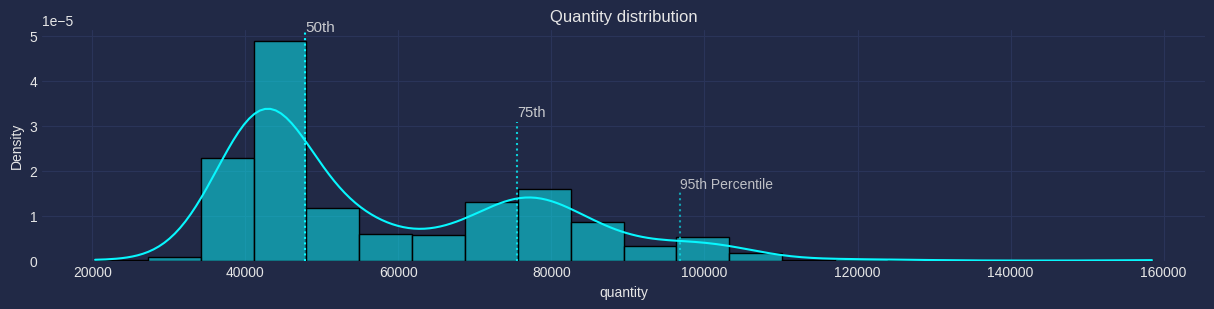

In [47]:
aux = df.groupby("date", as_index=False).quantity.sum()
plt.figure(figsize=(15, 3))
sns.histplot(data=aux, x="quantity", kde=True, stat="density");

quant_50, quant_75, quant_95 = aux.quantity.quantile(0.5), aux.quantity.quantile(0.75), aux.quantity.quantile(0.95)
quants = [[quant_50, 1, 2],  [quant_75, 0.8, 0.6], [quant_95, 0.6, 0.3]]
for i in quants:
    plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

plt.text(quant_50-.13, .000051, "50th", size = 11, alpha = .85)
plt.text(quant_75-.13, .000032, "75th", size = 10.5, alpha = .85)
plt.text(quant_95-.25, .000016, "95th Percentile", size = 10, alpha =.8);
plt.title("Quantity distribution");

75% of the items accumulate fewer than 80,000 sold products. 50% of the items accumulate fewer than 60,000 sold products.

### Quantity feature in the time

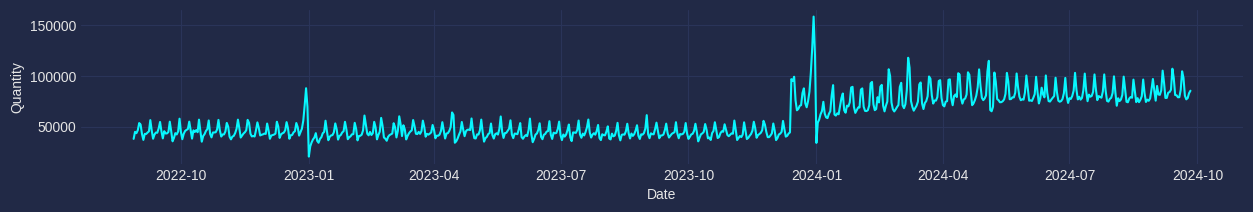

In [48]:
plt.figure(figsize=(15, 2))
sns.lineplot(aux, x="date", y="quantity")
plt.xlabel("Date")
plt.ylabel("Quantity");

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


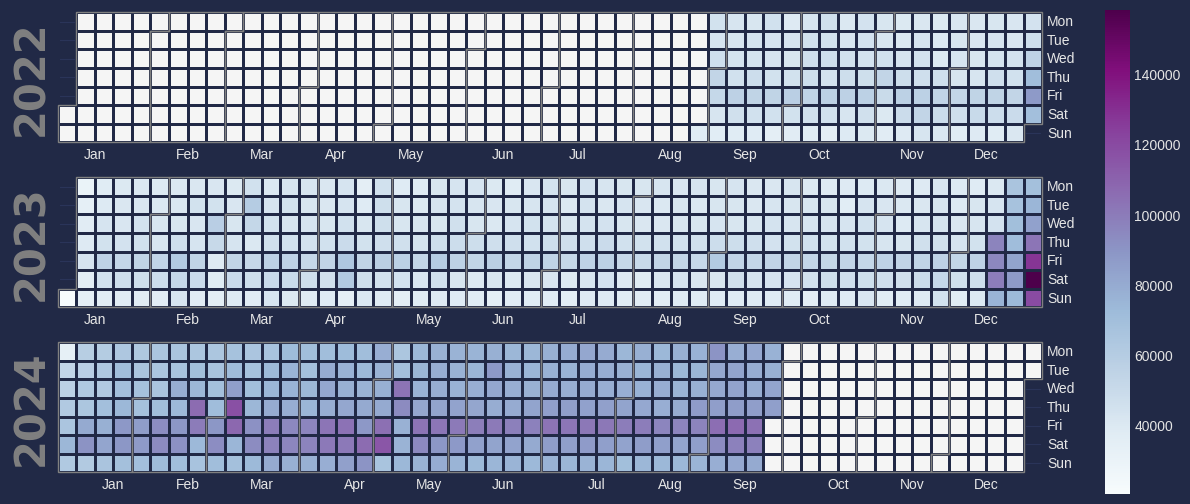

In [49]:
aux = df.groupby(["date"]).quantity.sum()
clp(aux, cmap='BuPu');

The quantity feature is constant throughout the year. At the end of the old year and the start of the new year, we can see a peak. This is due to Christmas Day and New Year's Day, when people buy more products at the same time.

### Quantities by store

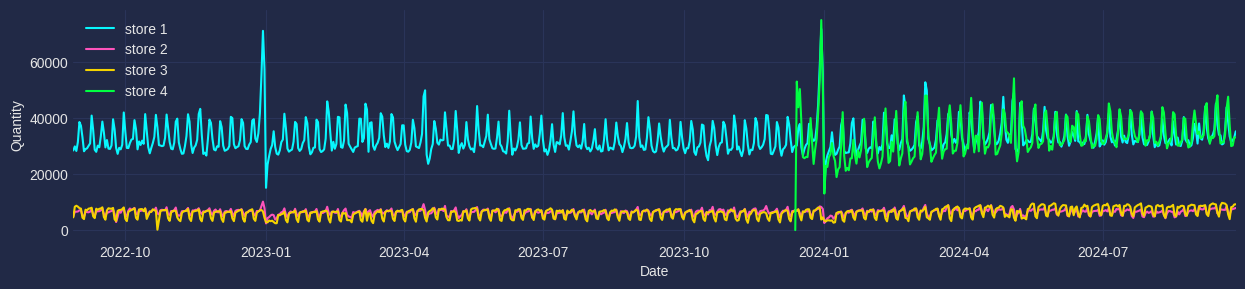

In [50]:
colors = [
    '#08F7FE',
    '#FE53BB',
    '#F5D300',
    '#00ff41',
]

aux = df.groupby(by=["date", "store_id"], as_index=False).quantity.sum()

plt.figure(figsize=(15, 3))
for i in range(4):
    aux2 = aux[aux.store_id == i+1]
    plt.plot(aux2.date, aux2.quantity, label=f"store {i+1}", color=colors[i])
    
plt.legend()
plt.xlim(aux.date.min(), aux.date.max())
plt.xlabel("Date")
plt.ylabel("Quantity");

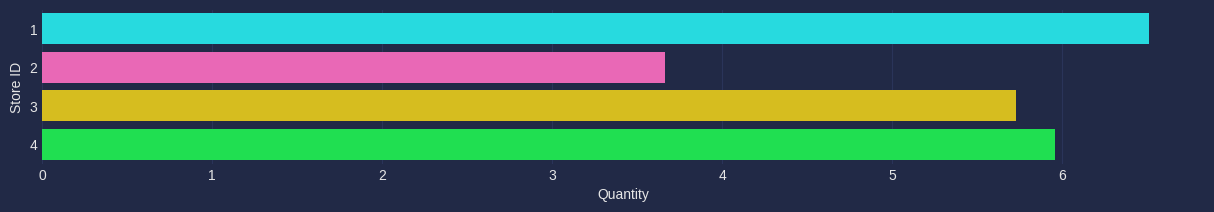

In [51]:
aux = df.groupby(by=["store_id"], as_index=False).quantity.mean()
aux.store_id = aux.store_id.apply(str)
plt.figure(figsize=(15, 2))
sns.barplot(data=aux, y="store_id", x="quantity", orient="h")
plt.ylabel("Store ID")
plt.xlabel("Quantity");

Some important aspects:
+ Store 1 and store 4 are the stores with the highest sales throughout the year.
+ Store 4 started selling approximately in 2024.
+ Store 2 is the store with the lowest sales.

### Quantity distribution by store

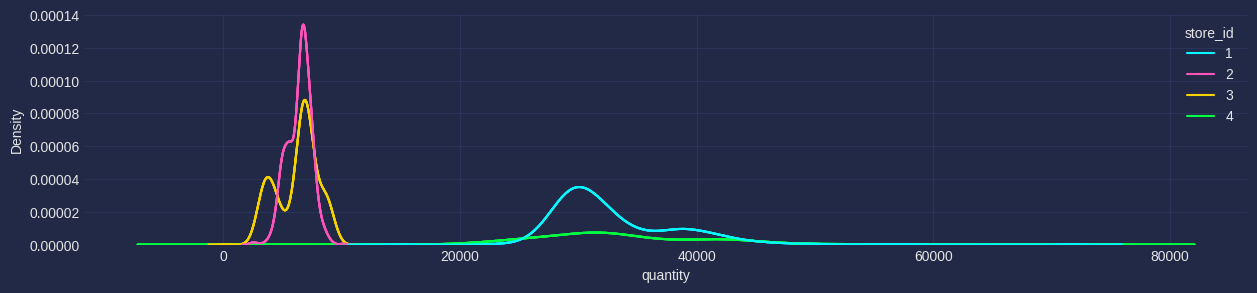

In [52]:
aux = df.groupby(by=["date", "store_id"], as_index=False).quantity.sum()
plt.figure(figsize=(15, 3))
for i in range(4):
    sns.kdeplot(aux, x="quantity", hue="store_id", palette=colors)

### Normalization of the quantity distribution

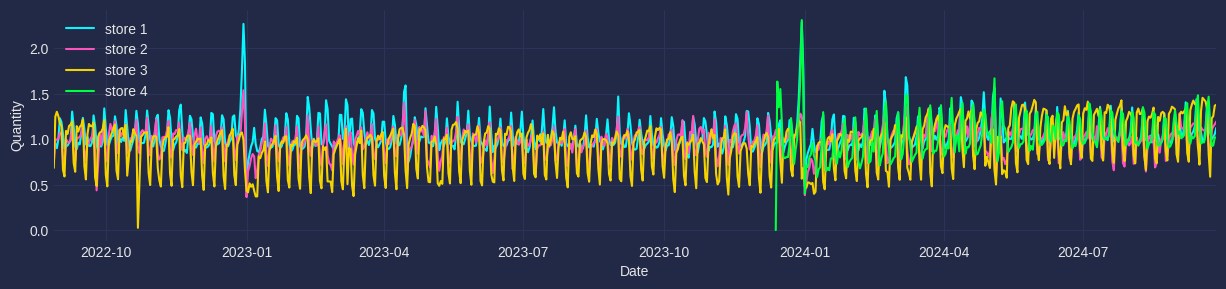

In [53]:
aux = df.groupby(by=["date", "store_id"], as_index=False).quantity.sum()

plt.figure(figsize=(15, 3))
for i in range(4):
    aux2 = aux[aux.store_id == i+1]
    k = aux2.quantity.median()
    plt.plot(aux2.date, aux2.quantity/k, label=f"store {i+1}", color=colors[i])
    
plt.legend()
plt.xlim(aux.date.min(), aux.date.max())
plt.xlabel("Date")
plt.ylabel("Quantity");

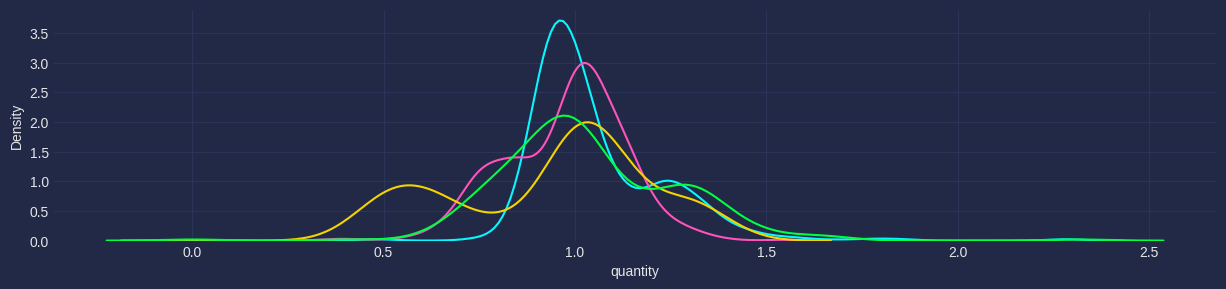

In [54]:
aux = df.groupby(by=["date", "store_id"], as_index=False).quantity.sum()

plt.figure(figsize=(15, 3))
for i in range(4):
    aux2 = aux[aux.store_id == i+1]
    k = aux2.quantity.median()
    sns.kdeplot(aux2.quantity/k, color=colors[i])

### Fractions decomposition

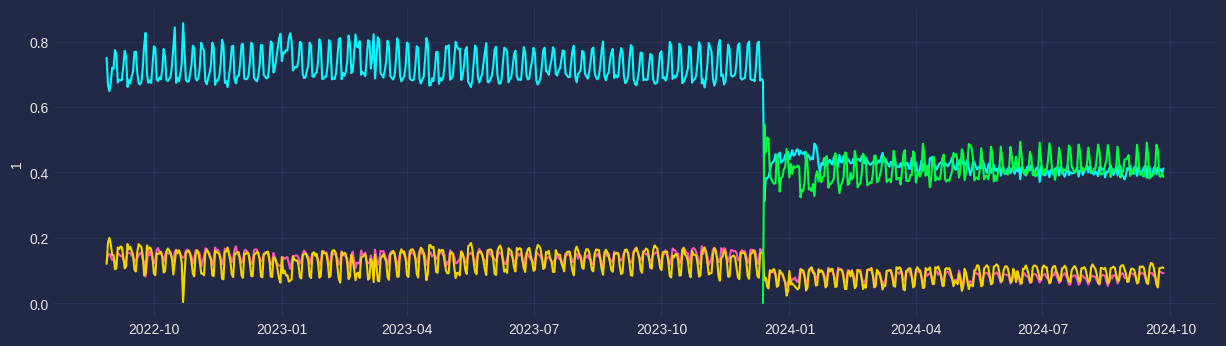

In [55]:
plt.figure(figsize=(15, 4))
quantity_fractions = {}
quantity_per_column = df.groupby(['date', "store_id"])["quantity"].sum().reset_index().pivot(index="date", columns="store_id", values='quantity').reset_index(drop=True)
quantity_fractions["store_id"] = quantity_per_column.divide(quantity_per_column.sum(axis=1), axis=0)
for i in range(4):
    sns.lineplot(x=df.date.unique(), y=quantity_fractions["store_id"][i+1]);

We calculate the time dependence of ratios of sold products per store. It seems, that store has stepwise dependence on year.

## Quantity by item type

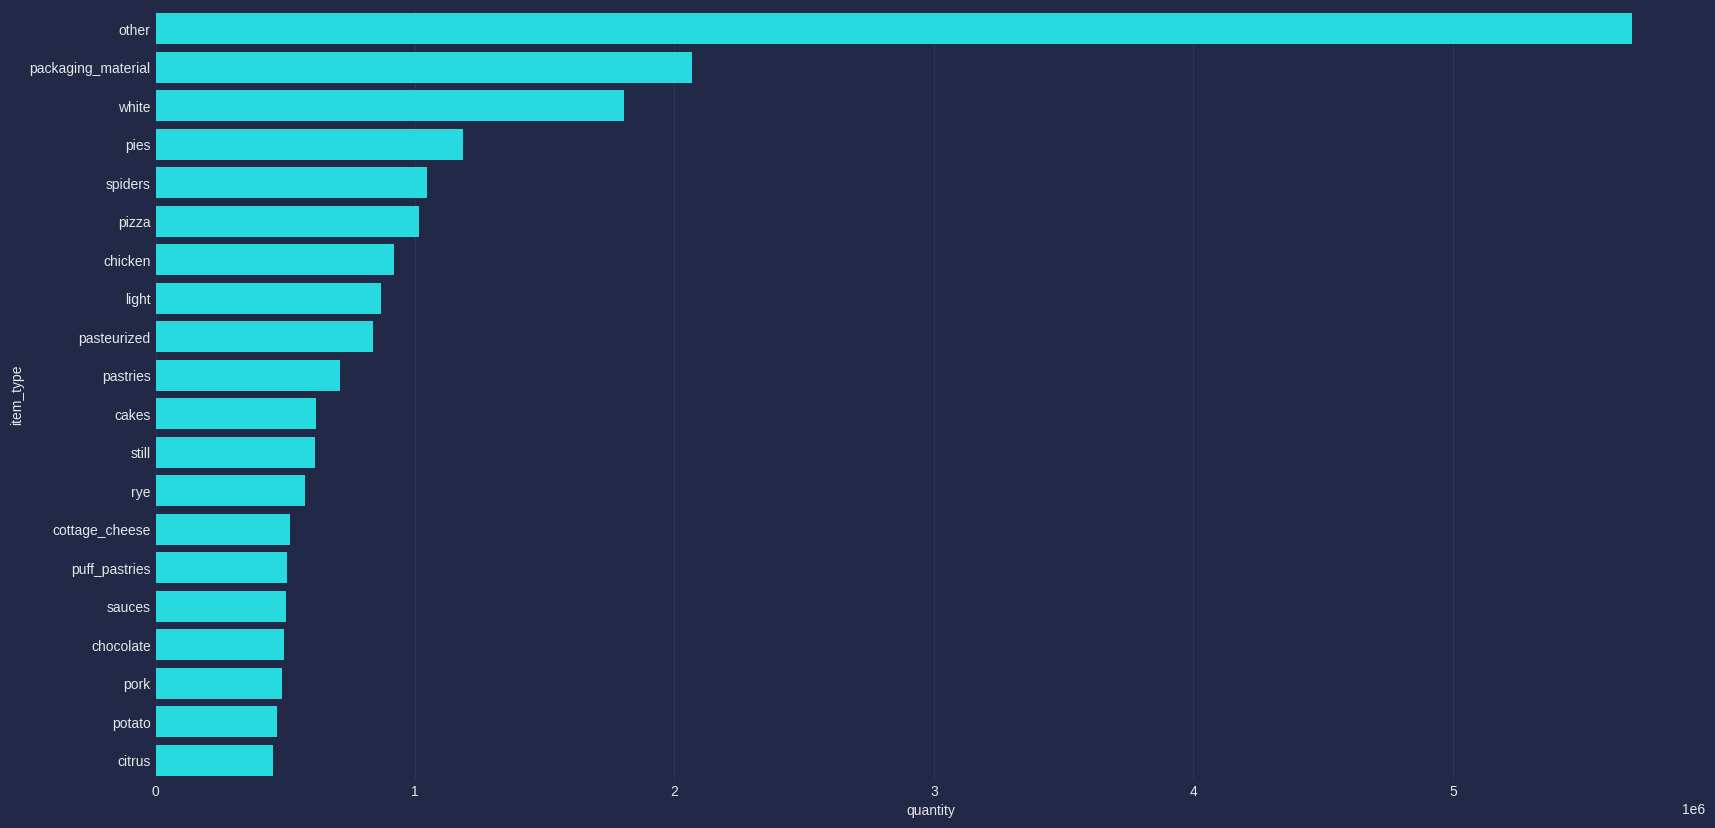

In [56]:
aux = df.groupby(["item_type"], as_index=False).quantity.sum().sort_values(by="quantity", ascending=False)[:20]

plt.figure(figsize=(20, 10))
sns.barplot(aux, y="item_type", x="quantity", color=colors[0]);

# Feature Engineering
## Extracting features of the date column

In [57]:
def date_features(dataframe):
    dataframe["day"] = dataframe.date.dt.day
    dataframe["month"] = dataframe.date.dt.month
    dataframe["year"] = dataframe.date.dt.year
    dataframe['dayofweek'] = dataframe['date'].dt.dayofweek 
    dataframe['week'] = dataframe['date'].dt.isocalendar().week
    return dataframe
    
df = date_features(df)
df_test = date_features(df_test)

To visualize the time features, we'll use the mean quantity since the years 2022 and 2024 aren't complete.

### Quantity per year

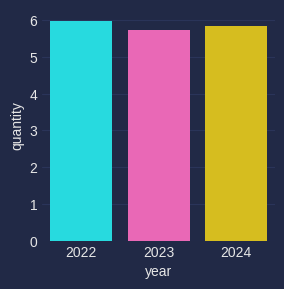

In [58]:
plt.figure(figsize=(3, 3))
aux = df.groupby(["year"]).quantity.mean().reset_index()
aux.year = aux.year.apply(str)
sns.barplot(y=aux.quantity, x=aux.year);

2022 is the year with the highest quantity sold. 2023 had fewer sales than 2024, but this could be because Store 4 started selling in 2024

### Quantity per day of the week

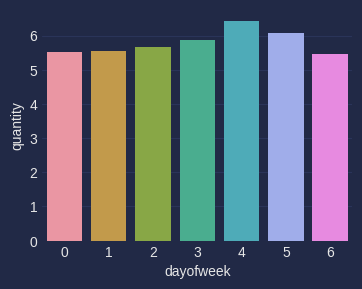

In [59]:
plt.figure(figsize=(4, 3))
aux = df.groupby(["dayofweek"]).quantity.mean().reset_index()
aux.dayofweek = aux.dayofweek.apply(str)
sns.barplot(y=aux.quantity, x=aux.dayofweek);

Friday is the best day to sell. The worst day is Sunday.

### Quantity per month

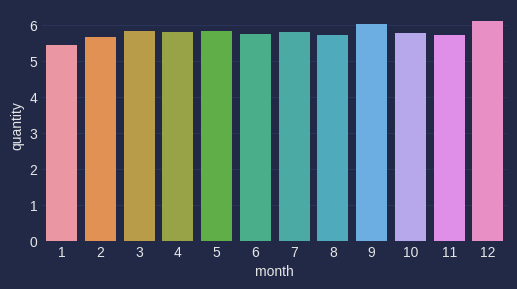

In [60]:
plt.figure(figsize=(6, 3))
aux = df.groupby(["month"]).quantity.mean().reset_index()
aux.month = aux.month.apply(str)
sns.barplot(y=aux.quantity, x=aux.month);

SSeptember and December are the best months to sell. The worst month to sell is January

### Quantity per week of the year

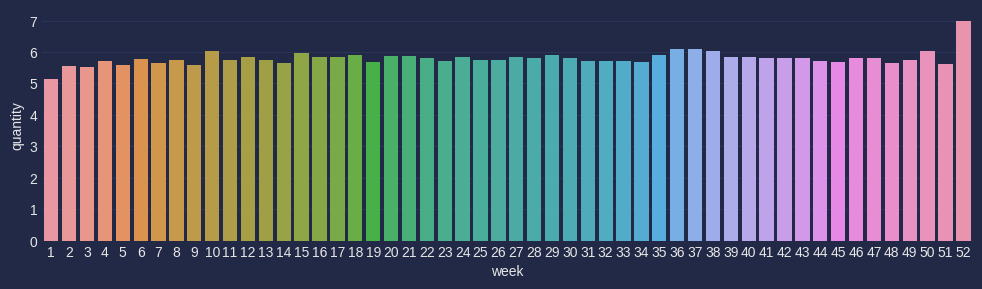

In [61]:
plt.figure(figsize=(12, 3))
aux = df.groupby(["week"]).quantity.mean().reset_index()
aux.week = aux.week.apply(str)
sns.barplot(y=aux.quantity, x=aux.week);

Because of Christmas and New Year's Day, the last week of the year is the best time to sell.

## The cyclic nature of time
In all the cases, but Year, the features should be split into two parts: sinus and cosine, to reflect cyclicity, e.g. the 1st January is near the 31st December.

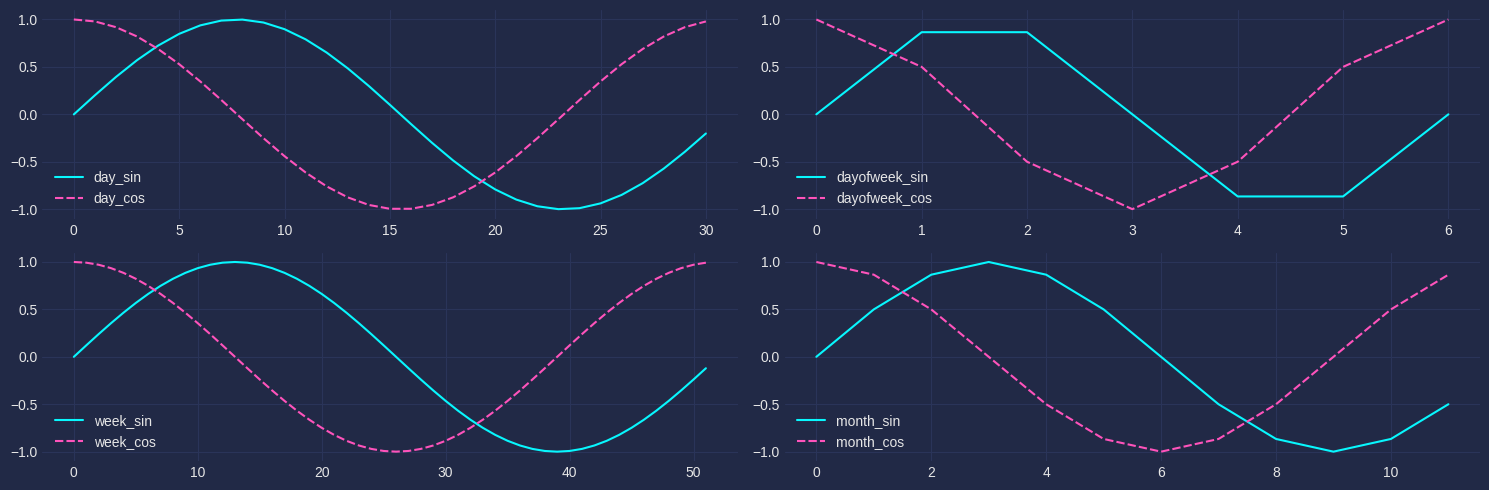

In [62]:
def transform2cyclic(dataframe):
    dataframe['day_sin'] = np.sin(2 * np.pi * (dataframe['day']-1)/31)
    dataframe['day_cos'] = np.cos(2 * np.pi * (dataframe['day']-1)/31)
    
    dataframe['dayofweek_sin'] = np.sin(2 * np.pi * dataframe['dayofweek']/6)
    dataframe['dayofweek_cos'] = np.cos(2 * np.pi * dataframe['dayofweek']/6)
    
    dataframe['week_sin'] = np.sin(2 * np.pi * (dataframe['week']-1)/52)
    dataframe['week_cos'] = np.cos(2 * np.pi * (dataframe['week']-1)/52)
    
    dataframe['month_sin'] = np.sin(2 * np.pi * (dataframe['month']-1)/12)
    dataframe['month_cos'] = np.cos(2 * np.pi * (dataframe['month']-1)/12)
    return dataframe

df = transform2cyclic(df)
df_test = transform2cyclic(df_test)

plt.subplots(2, 2, figsize=(15, 5))
for i, col in enumerate(["day", "dayofweek", "week", "month"]):
    aux = df.groupby([col, col+"_sin", col+"_cos"]).quantity.mean().reset_index()
    aux[col] = aux[col].apply(str)
    plt.subplot(2, 2, i+1)
    sns.lineplot(data=aux[[col+"_sin", col+"_cos"]])
plt.tight_layout()

## Weekends

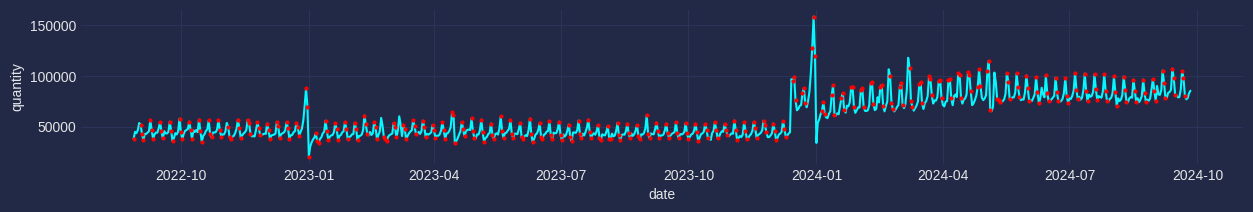

In [63]:
def get_weekends(dataframe):
    dataframe["is_weekend"] = dataframe['dayofweek'].isin([4, 5, 6])
    return dataframe

df = get_weekends(df)
df_test = get_weekends(df_test)

plt.figure(figsize=(15, 2))
aux = df.groupby(["date", "is_weekend"]).quantity.sum().reset_index()
sns.lineplot(data=aux, x="date", y="quantity");
aux2 = aux.loc[aux["is_weekend"] == True, ["date", "quantity"]]
plt.plot(aux2.date, aux2.quantity, "ro", markersize=2);

## Sundays

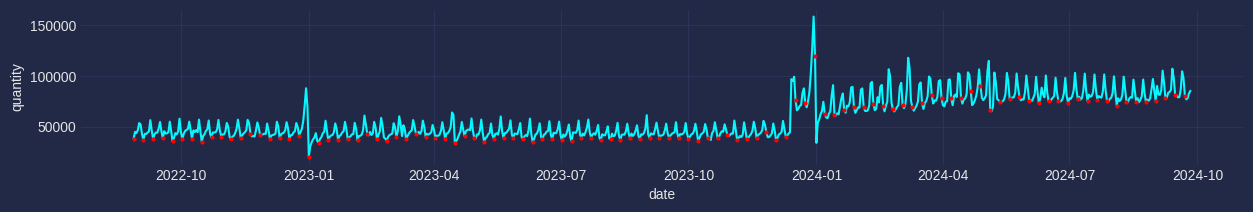

In [64]:
def get_sundays(dataframe):
    dataframe["is_sunday"] = dataframe['dayofweek'].eq(6)
    return dataframe

df = get_sundays(df)
df_test = get_sundays(df_test)

plt.figure(figsize=(15, 2))
aux = df.groupby(["date", "is_sunday"]).quantity.sum().reset_index()
sns.lineplot(data=aux, x="date", y="quantity");
aux2 = aux.loc[aux["is_sunday"] == True, ["date", "quantity"]]
plt.plot(aux2.date, aux2.quantity, "ro", markersize=2);

Again, Sundays is the worst day to sell.

## The holidays in Russia

Since the catalog was in Russian, I can assume that these stores are from Russia; therefore, sales may be affected by Russia holidays.

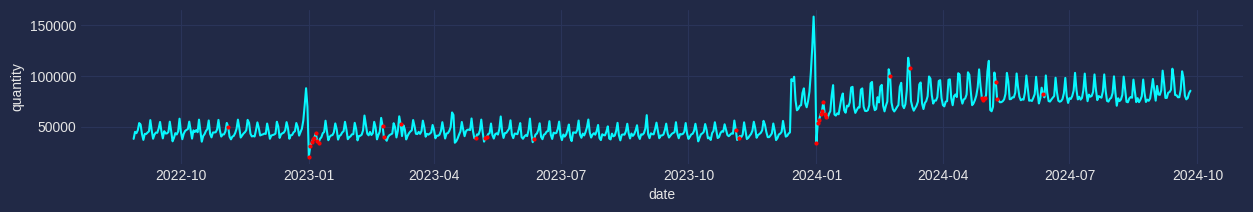

In [65]:
def get_holidays(dataframe):
    RU_holidays = holidays.CountryHoliday('RU', years=[2022, 2023, 2024])
    dataframe["holidays"] = False
    dataframe.loc[df.date.isin(RU_holidays.keys()), "holidays"] = True
    return dataframe

df = get_holidays(df)
df_test = get_holidays(df_test)

plt.figure(figsize=(15, 2))
aux = df.groupby(["date", "holidays"]).quantity.sum().reset_index()
sns.lineplot(data=aux, x="date", y="quantity");
aux2 = aux.loc[aux["holidays"] == True, ["date", "quantity"]]
plt.plot(aux2.date, aux2.quantity, "ro", markersize=2);

## GDP per capita in Russia

The purchasing capacity of people is a good indicator of whether a person is able to buy or not, how often they shop at a store, etc. GDP per capita is an indicator that measures the wealth of a country or region per inhabitant.

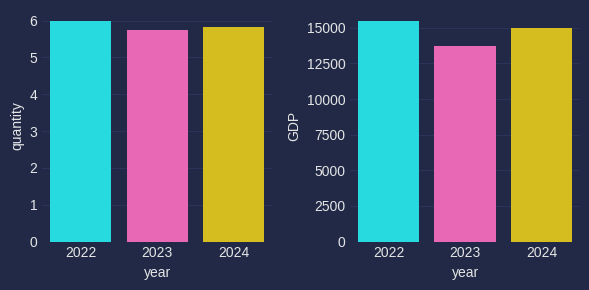

In [66]:
indicator = "NGDPDPC"
country = "RUS"
periods = "2022,2023,2024"

url = f"https://www.imf.org/external/datamapper/api/v1/{indicator}/{country}?periods={periods}"
response = requests.get(url).json()
gdp = response["values"][indicator][country]

plt.subplots(1, 2, figsize=(6, 3))
aux = df.groupby(["year"]).quantity.mean().reset_index()
aux.year = aux.year.apply(str)
plt.subplot(1, 2, 1)
sns.barplot(y=aux.quantity, x=aux.year);
plt.subplot(1, 2, 2)
sns.barplot(y=list(gdp.values()), x=list(gdp.keys()));
plt.ylabel("GDP")
plt.xlabel("year")
plt.tight_layout()

Wow! GDP per capita has a relationship with the quantity feature per year. If GDP falls, the quantity sold also falls.

## The seasons in Russia

Russia has four seasons:
+ Spring (1): From April to May.
+ Summer (2): From June to August.
+ Autumn (3): From September to October.
+ Winter (4): From November to March.

In [67]:
def get_seasons(dataframe):
    dataframe["season"] = 0
    dataframe.loc[(dataframe.month == 4) | (dataframe.month == 5), "season"] = 1
    dataframe.loc[(dataframe.month >= 6) & (dataframe.month <= 8), "season"] = 2
    dataframe.loc[(dataframe.month == 9) | (dataframe.month == 10), "season"] = 3
    dataframe.loc[((dataframe.month >= 1) & (dataframe.month <= 3)) | (dataframe.month == 11) | (dataframe.month == 12), "season"] = 4
    return dataframe

df = get_seasons(df)
df_test = get_seasons(df_test)

## Dropping the redundant features

In [68]:
df.columns

Index(['date', 'item_id', 'quantity', 'price_base', 'sum_total', 'store_id',
       'division', 'format', 'city', 'area', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto', 'day',
       'month', 'year', 'dayofweek', 'week', 'day_sin', 'day_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'is_weekend', 'is_sunday', 'holidays', 'season'],
      dtype='object')

In [69]:
cols = ['date', 
        'day', 
        'dayofweek', 
        'week', 
        'month', 
        'price_base', 
        'sum_total']
df.drop(columns=cols, inplace=True)

In [70]:
df_test.columns

Index(['date', 'item_id', 'quantity', 'price_base', 'sum_total', 'store_id',
       'division', 'format', 'city', 'area', 'dept_name', 'class_name',
       'subclass_name', 'item_type', 'weight_volume', 'weight_netto', 'day',
       'month', 'year', 'dayofweek', 'week', 'day_sin', 'day_cos',
       'dayofweek_sin', 'dayofweek_cos', 'week_sin', 'week_cos', 'month_sin',
       'month_cos', 'is_weekend', 'is_sunday', 'holidays', 'season'],
      dtype='object')

In [71]:
df_test.drop(columns=cols+["quantity"], inplace=True)

## Reduce the memory usage

In [72]:
gc.collect()

df = optimizing_dtypes(df, nameCSV="df.csv")
df_test = optimizing_dtypes(df_test, nameCSV="df_test.csv")

df.csv: from 1576.91MB reduced to 1241.72MB
df_test.csv: from 149.17MB reduced to 110.4MB


# Split the dataset

In [73]:
X = df.drop(["quantity"], axis=1)
y = df["quantity"]

## Creating a pipeline

### Selecting columns by data type

In [74]:
numerical_cols = X.select_dtypes([np.int32, np.int64, np.float32, np.float64]).columns.to_list()
categorical_cols = X.select_dtypes('object').columns.to_list()
numerical_cols, categorical_cols

(['store_id',
  'area',
  'weight_volume',
  'weight_netto',
  'year',
  'day_sin',
  'day_cos',
  'dayofweek_sin',
  'dayofweek_cos',
  'week_sin',
  'week_cos',
  'month_sin',
  'month_cos',
  'season'],
 ['item_id',
  'division',
  'format',
  'city',
  'dept_name',
  'class_name',
  'subclass_name',
  'item_type'])

### Pipeline

In [75]:
column_transformer = make_column_transformer(
    # Numerical columns
    (
        StandardScaler(),
        numerical_cols
    ),
    # Categorical columns
    (
        OneHotEncoder(handle_unknown='ignore', drop='first'),
        categorical_cols
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_transformed = column_transformer.fit_transform(X)
X_test_transformed = column_transformer.transform(df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Creating the validation framework

In [76]:
seed_value = 42
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, train_size=0.95, random_state=seed_value)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7258714, 30365) (7258714,)
(382038, 30365) (382038,)


# Let's train

In [77]:
model_file = "catboost_clf_1"

if os.path.exists(f"/kaggle/working/{model_file}"):
    model = CatBoostRegressor().load_model(fname=f"/kaggle/working/{model_file}.cbm")
else:
    model = CatBoostRegressor(
        iterations = 5000,
        learning_rate = 0.5,
        depth = 12,
        l2_leaf_reg = 2,
        early_stopping_rounds = 20,
        loss_function='RMSE',
        eval_metric='RMSE',
        langevin=True,
        random_state=seed_value,
        verbose=True
    )
        
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )
    model.save_model(f"/kaggle/working/{model_file}.cbm")
    
    print(f"RMSE: {RMSE(y_val, model.predict(X_val))}") #6.138 (6)

0:	learn: 18.8428282	test: 17.5959632	best: 17.5959632 (0)	total: 6.14s	remaining: 8h 31m 33s
1:	learn: 15.3172307	test: 14.4377075	best: 14.4377075 (1)	total: 11.5s	remaining: 7h 57m 47s
2:	learn: 13.9101501	test: 13.1872215	best: 13.1872215 (2)	total: 17s	remaining: 7h 51m 43s
3:	learn: 13.2158626	test: 12.5182719	best: 12.5182719 (3)	total: 22.2s	remaining: 7h 42m 49s
4:	learn: 12.7793255	test: 12.0751828	best: 12.0751828 (4)	total: 27.4s	remaining: 7h 35m 40s
5:	learn: 12.3626722	test: 11.8052713	best: 11.8052713 (5)	total: 32.8s	remaining: 7h 35m 31s
6:	learn: 12.0815368	test: 11.4833190	best: 11.4833190 (6)	total: 38s	remaining: 7h 31m 26s
7:	learn: 11.8614078	test: 11.2645367	best: 11.2645367 (7)	total: 43.2s	remaining: 7h 28m 52s
8:	learn: 11.6359395	test: 11.0430153	best: 11.0430153 (8)	total: 48.9s	remaining: 7h 31m 53s
9:	learn: 11.4434481	test: 10.8533755	best: 10.8533755 (9)	total: 54s	remaining: 7h 29m 13s
10:	learn: 11.2232389	test: 10.7264788	best: 10.7264788 (10)	total

# Create my submission

## Let's take a look at the sample submission file

In [78]:
df_sample_submission.head()

,quantity
row_id,
0,0
1,0
2,0
3,0
4,0


## Performing predictions for my submission file using the test dataset.

In [79]:
quantity_pred = model.predict(X_test_transformed)
df_test["quantity"] = quantity_pred
df_submission = df_test[["quantity"]]
df_submission.head()

,quantity
0,6.6874
1,5.4684
2,5.0966
3,5.1127
4,5.2116


## Looking for unknown items in the test dataset

In [80]:
missing_items = df_test[~df_test.item_id.isin(df.item_id)]
missing_items.head()

,item_id,store_id,division,format,city,area,dept_name,class_name,subclass_name,item_type,...,dayofweek_cos,week_sin,week_cos,month_sin,month_cos,is_weekend,is_sunday,holidays,season,quantity
12750,4.74E+240,1,Div1,Format-1,City1,1500,other,other,other,other,...,-0.5000,-0.9927,-0.1205,-0.8660,-0.5000,True,False,False,3,4.0717
12751,4.74E+240,1,Div1,Format-1,City1,1500,other,other,other,other,...,0.5000,-0.9927,-0.1205,-0.8660,-0.5000,True,False,False,3,3.6639
12752,4.74E+240,1,Div1,Format-1,City1,1500,other,other,other,other,...,1.0000,-0.9927,-0.1205,-0.8660,-0.5000,True,True,False,3,3.4207
12753,4.74E+240,1,Div1,Format-1,City1,1500,other,other,other,other,...,1.0000,-1.0000,-0.0000,-0.8660,-0.5000,False,False,False,3,3.3263
12754,4.74E+240,1,Div1,Format-1,City1,1500,other,other,other,other,...,0.5000,-1.0000,-0.0000,-1.0000,-0.0000,False,False,False,3,3.4251


Since we don't have any information about these items, I decided to fill their quantity with zero units sold.

In [81]:
df_submission.loc[missing_items.index, "quantity"] = 0

<ipython-input-81-bc4012353b37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission.loc[missing_items.index, "quantity"] = 0


## Save my submission

In [82]:
df_submission = optimizing_dtypes(df_submission, nameCSV="df_test.csv")
df_submission.to_csv("submission.csv", index_label='row_id')

df_test.csv: from 45.73MB reduced to 42.36MB


<ipython-input-4-e9ff92812f94>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_float64] = df.select_dtypes(include=["float64"]).astype("float32", copy=False)


### 🖐️ Thank you for your time!